In [0]:
from pyspark.sql.functions import col
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from pyspark.sql import functions as f
from pyspark.sql.types import StructType, StructField, StringType, DoubleType, IntegerType, NullType, ShortType, DateType, BooleanType, BinaryType, FloatType
from pyspark.sql import SQLContext
from pyspark.sql.functions import when
import matplotlib.pyplot as plt
import numpy as np
from pyspark.sql.functions import col
from pyspark.sql import types, Window
from pyspark.sql.functions import count, percent_rank
import itertools 
import os
import time
from pytz import timezone 
from datetime import  datetime, timedelta 
from delta.tables import DeltaTable
import datetime as dt
import pytz

from pyspark.ml import Pipeline
from pyspark.ml.feature import StringIndexer, VectorAssembler, StandardScaler, OneHotEncoder 
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, GBTClassifier
from sklearn.metrics import classification_report
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics, MulticlassMetrics

%matplotlib inline
sqlContext = SQLContext(sc)

# Data 
Load data, join normalized weather features and graph features. 
Split training, validation and test datasets

In [0]:
def time_series_cross_validation_split(num_folds, df, sort_order_column_name, dependent_column_name):
    if sort_order_column_name not in df.columns or dependent_column_name not in df.columns:
        return
    df = df.withColumn("rank", percent_rank().over(Window.partitionBy().orderBy(sort_order_column_name)))
    fold_percentage = 1 / (num_folds + 2)
    df_train_list = []
    df_validate_list = []
    df_test_list = []
    for i in range(1, num_folds + 1):
        train_df = df.where("rank <= " + str(fold_percentage * i)).drop("rank")
        validate_df = df.where("rank <= " + str(fold_percentage * (i + 1)) + " and rank > " + str(fold_percentage * i)).drop("rank")
        test_df = df.where("rank <= " + str(fold_percentage * (i + 2)) + " and rank > " + str(fold_percentage * (i + 1))).drop("rank")
        df_train_list.append(train_df)
        df_validate_list.append(validate_df)
        df_test_list.append(test_df)
    return df_train_list, df_validate_list, df_test_list

In [0]:
df_full_joined_name = "/mnt/v2team11/full_joined_flight_weather_graph_delay_features_v2/"
df_full_joined = spark.read.parquet(df_full_joined_name)

### Split data into train/validation/test

In [0]:
df_2015_2018_joined = df_full_joined.filter((f.col("YEAR")<2019))
df_2019_joined = df_full_joined.filter((f.col("YEAR")==2019))
df_train_list, df_validation_list, df_test_list = time_series_cross_validation_split(3, df_2015_2018_joined, "CRS_DEP_DATETIME", "DEP_DEL15")

# Model Feature Pipeline

Airline:
Carrier, departure airport, arrival airport, distance, scheduled departure time, scheduled arrival time, time of day, day of week

Weather:
Elevation, wind direction, wind speed, ceiling height, visibility distance, air temperature, dew point temperature, sea level pressure, liquid precipitation

### Encoding Features

In [0]:
def encoding_features(cat_var, num_var):
    
    #Specify Categorical Variables to be string indexed and encoded
    ### Used Distance_group instead of distance
    ### scheduled departure time&scheduled arrival time >> need some feature engineering?
    #Empty vector to store pipeline
    stages = []

    #Use the OneHotEncoderEstimator to convert categorical features into one-hot vectors
    #Loop through the specified categorical variables 
    for CatVar in cat_var:
        #Encoding
        stringIndexer = StringIndexer(inputCol = CatVar, outputCol = CatVar+'_Index', handleInvalid='skip')

        #Rename (Column Name + "ClassVec")
        encoder = OneHotEncoder(inputCols = [stringIndexer.getOutputCol()],outputCols = [CatVar + "classVec"], handleInvalid='error')

        #Temp staging the encoder
        stages +=[stringIndexer, encoder]

    #Label outcome variable "DEP_DEL15" as "label" 
    label_index = StringIndexer(inputCol = 'DEP_DEL15', outputCol = 'label', handleInvalid='skip')

    #Stage the labeling var (Dep_Delay15)
    stages +=[label_index]

    #Use vector assembler with only the features of interest (categorical and numerical)
    assemblerInputs = [c+'classVec' for c in cat_var] + num_var

    #Pass it through the vector assembler to get the feature vector
    assembler = VectorAssembler(inputCols = assemblerInputs, outputCol = 'features', handleInvalid = 'skip')

    #Append the process into the stages array to reproduce
    stages += [assembler]
    return (assemblerInputs, stages)

### Create a function of model performance metrics

In [0]:
## Create a function of evaluation metrics for model predictions
def evaluation_metrics(predictions, model_name):
    predictions = predictions.createOrReplaceTempView('predictions')
    display(predictions)
    true_positives = spark.sql("SELECT COUNT(*) FROM predictions WHERE predictions.label = 1 AND predictions.prediction = 1").collect()[0][0]
    true_negatives = spark.sql("SELECT COUNT(*) FROM predictions WHERE predictions.label = 0 AND predictions.prediction = 0").collect()[0][0]
    false_positives = spark.sql("SELECT COUNT(*) FROM predictions WHERE predictions.label = 0 AND predictions.prediction = 1").collect()[0][0]
    false_negatives = spark.sql("SELECT COUNT(*) FROM predictions WHERE predictions.label = 1 AND predictions.prediction = 0").collect()[0][0]

    # Now we should compute our main statistics
    accuracy = (true_positives + true_negatives)/(true_positives + true_negatives + false_positives + false_negatives)
    recall = (true_positives) / (true_positives + false_negatives)
    precision = (true_positives) / (true_positives + false_positives) if (true_positives + false_positives) != 0 else 0
    f1_score = (2 * recall * precision) / (recall + precision) if (recall + precision) != 0 else 0

    print("The accuracy is: %s" % np.round(accuracy, 4))
    print("The recall is: %s" % np.round(recall, 4))
    print("The precision is: %s" % np.round(precision, 4))
    print("The f1_score is: %s" % np.round(f1_score, 4))
    df_cols = ['Model','accuracy', 'precision', 'recall', 'f1_score', 'true_positives', 'true_negatives', 'false_positives', 'false_negatives']
    metrics_dataframe = pd.DataFrame(columns = df_cols)
    result_dict = {'Model': model_name,
                 'accuracy': accuracy,
                 'precision': precision, 
                 'recall': recall, 
                 'f1_score': f1_score, 
                 'true_positives': true_positives, 
                 'true_negatives': true_negatives, 
                 'false_positives': false_positives, 
                 'false_negatives': false_negatives}
    metrics_dataframe = metrics_dataframe.append(result_dict, ignore_index=True)

    return metrics_dataframe

def confusion_matrix(model_preds):
    rdd_preds = model_preds.select(['prediction', 'label']).rdd
    confusion_matrix = MulticlassMetrics(rdd_preds).confusionMatrix().toArray()
    confusion_matrix = pd.DataFrame(confusion_matrix)
    ax = plt.axes()
    sn.heatmap(confusion_matrix, annot=True, cmap= 'Blues', fmt=',', ax=ax)
    size = f'{int(model_preds.count()):,}'
    ax.set_title('Confusion Matrix - N={}'.format(size))
    ax.set_ylabel('Actual Values')
    ax.set_xlabel('Predicted Values')
    plt.show()
    
def AUC(model, predictions):
    evaluator = BinaryClassificationEvaluator()
    evaluation = evaluator.evaluate(predictions)
    print("evaluation (area under ROC): %f" % evaluation)
    return evaluation

#https://newbedev.com/pyspark-extract-roc-curve
class CurveMetrics(BinaryClassificationMetrics):
    def __init__(self, *args):
        super(CurveMetrics, self).__init__(*args)

    def _to_list(self, rdd):
        points = []
        # Note this collect could be inefficient for large datasets 
        # considering there may be one probability per datapoint (at most)
        # The Scala version takes a numBins parameter, 
        # but it doesn't seem possible to pass this from Python to Java
        for row in rdd.collect():
            # Results are returned as type scala.Tuple2, 
            # which doesn't appear to have a py4j mapping
            points += [(float(row._1()), float(row._2()))]
        return points

    def get_curve(self, method):
        rdd = getattr(self._java_model, method)().toJavaRDD()
        return self._to_list(rdd)
    
def ROC(predictions, data_group):
    """
    predictions: prediction results from a ML model
    data_group: String "train"/"validation"/"test" for plot title
    """
    preds = predictions.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
    points = CurveMetrics(preds).get_curve('roc')

    plt.figure()
    x_val = [x[0] for x in points]
    y_val = [x[1] for x in points]
    plt.title(f"ROC AUC curve ( {data_group} )")
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.plot(x_val, y_val)


### Gradient Boosted Tree Model

### Hyperparameter tuning

In [0]:
def run_model(model_type, data, p):
    """
        Train a model with specfied parameters and data df
        model_type: String "gbt", "lr"
        data: dataframe
        p: Dictionary of hyperparameters
        
        Returns a model and predictions
    """
    if model_type == "gbt":
        gbt = GBTClassifier(maxDepth=p[0], maxBins=p[1], maxIter=p[2], stepSize=p[3])
        model = gbt.fit(data)
        
    elif model_type == "lr":
        lr = LogisticRegression(featuresCol = 'features', labelCol = 'label', maxIter = p[0], regParam = p[1], elasticNetParam = p[2], standardization = False)
        model = lr.fit(data)
    
    preds = model.transform(data)
    return (model, preds)

def parameter_search(model_type, train_df, valid_df, pipeline, assemblerInputs, dictionary):
    best_score = 0
    best_param_vals = None
    best_params_result = {}
    # Track score
    scores=[]
    
    # Create a dictionary combination of the parameter grid
    parameter_names = list(dictionary.keys())
    v = dictionary.values()
    parameters = list(itertools.product(*v))
    
    for p in parameters:

        for i in range(0, len(train_df)):
            #Fit the pipeline onto the dataset
            train = train_df[i]
            valid = valid_df[i]
            PipelineModel = pipeline.fit(train)
            train = PipelineModel.transform(train)
            valid = PipelineModel.transform(valid)
            
            #Only select the features of interest to pass into the model
            selectedCols =  ['label','features'] + assemblerInputs
            train = train.select(selectedCols)
            valid = valid.select(selectedCols)

            #Getting rid of label == 2
            train = train.where("label != 2")
            train.cache()
            valid = valid.where("label != 2")
            valid.cache()
            
            # train a model on our transformed train data
            # calculate AUC on validation data 
            model, preds = run_model(model_type, valid, p)
            current_score = AUC(model, preds)
            print(p)
            
            # Track the best score and model parameters
            scores.append(current_score)
            if best_param_vals == None or best_score < current_score:
                best_param_vals = p
                best_score = current_score

    for name, p in zip(parameter_names, best_param_vals):
        best_params_result[name] = p
    return best_params_result
        

In [0]:
# validate on best parameters
def validation(train_df, validation_df, num_var, cat_var, model_type, parameters):
    params = list(parameters.values())
    print(params)
    # encoding pipeline
    assemblerInputs, stages = encoding_features(cat_var, num_var)
    pipeline = Pipeline(stages = stages)
    for train, validate in zip(train_df, validation_df):
        print(validate.count())
        PipelineModel = pipeline.fit(train)
        train = PipelineModel.transform(train)
        valid = PipelineModel.transform(validate)
        print(valid.count())
        selectedCols =  ['label','features'] + assemblerInputs
        train = train.select(selectedCols)
        valid = valid.select(selectedCols)

        #Getting rid of label == 2
        train = train.where("label != 2")
        train.cache()
        valid = valid.where("label != 2")
        valid.cache()
        model, train_preds = run_model(model_type, train, params)
        model, validate_preds = run_model(model_type, valid, params)
        print("Training data:")
        AUC(model, train_preds)
        print("Validation/Test data:")
        AUC(model, validate_preds)
        
        train_metrics = evaluation_metrics(train_preds, f"{model_type} on train data")
        valid_metrics = evaluation_metrics(validate_preds, f"{model_type} on validation data")
        return model, validate_preds, train_preds, train_metrics, valid_metrics

In [0]:
# search the best parameters for GBT model
parameters = {'maxDepth':[7, 11], 'maxBins': [350], 'maxIter': [7,9], 'stepSize': [0.35, 0.45]}

###Round 1 Features Selection: Temporal + Location + Snowball Delay + Weather

'ORIGIN', 'DEST', 'OP_UNIQUE_CARRIER', 'DISTANCE_GROUP', 'CRS_DEP_TIME', 'CRS_ARR_TIME', DISTANCE_GROUP', 'CRS_DEP_TIME', 'CRS_ARR_TIME', "DEP_DEL15_PREV_FIN", "NUM_PREV_DELAYS_ORIGIN",
"ORIG_ELEVATION", "DEST_ELEVATION","ORIG_speed", "DEST_speed", "ORIG_ceiling_height", "DEST_ceiling_height", "ORIG_vis_distance", "DEST_vis_distance", "ORIG_air_temp", "ORIG_dew_point", "DEST_dew_point", "ORIG_sea_level_pressure", "DEST_sea_level_pressure", "CRS_DEP_TIME", "CRS_ARR_TIME", "ORIG_precipitation_depth", "DEST_precipitation_depth"

In [0]:
cat_var = ["OP_UNIQUE_CARRIER","ORIGIN","DEST","DISTANCE_GROUP", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK",  "DEP_DEL15_PREV_FIN"]
num_var = ['CRS_DEP_TIME', 'CRS_ARR_TIME', "ORIG_ELEVATION", "DEST_ELEVATION","ORIG_speed", "ORIG_ceiling_height", "DEST_ceiling_height", "ORIG_vis_distance", "DEST_vis_distance", "ORIG_air_temp", \
           "DEST_air_temp", "ORIG_dew_point", "DEST_dew_point", "ORIG_sea_level_pressure", "DEST_sea_level_pressure", "CRS_DEP_TIME", "CRS_ARR_TIME", "ORIG_precipitation_hrs", \
           "ORIG_precipitation_depth", "DEST_precipitation_hrs", "DEST_precipitation_depth", "NUM_PREV_DELAYS_ORIGIN"] 

In [0]:
# search the best parameters for GBT model
#Create a ML Pipeline Object and pass the stages vector
assemblerInputs, stages = encoding_features(cat_var, num_var)
pipeline = Pipeline(stages = stages)

gbt_best_params2 = parameter_search("gbt", df_train_list, df_validation_list, pipeline, assemblerInputs, parameters)

evaluation (area under ROC): 0.772867
(7, 350, 7, 0.35)
evaluation (area under ROC): 0.778754
(7, 350, 7, 0.35)
evaluation (area under ROC): 0.775568
(7, 350, 7, 0.35)
evaluation (area under ROC): 0.773825
(7, 350, 7, 0.45)
evaluation (area under ROC): 0.779923
(7, 350, 7, 0.45)
evaluation (area under ROC): 0.776762
(7, 350, 7, 0.45)
evaluation (area under ROC): 0.775970
(7, 350, 9, 0.35)
evaluation (area under ROC): 0.781128
(7, 350, 9, 0.35)
evaluation (area under ROC): 0.778515
(7, 350, 9, 0.35)
evaluation (area under ROC): 0.777592
(7, 350, 9, 0.45)
evaluation (area under ROC): 0.783368
(7, 350, 9, 0.45)
evaluation (area under ROC): 0.781004
(7, 350, 9, 0.45)
evaluation (area under ROC): 0.792654
(11, 350, 7, 0.35)
evaluation (area under ROC): 0.798610
(11, 350, 7, 0.35)
evaluation (area under ROC): 0.797108
(11, 350, 7, 0.35)
evaluation (area under ROC): 0.795742
(11, 350, 7, 0.45)
evaluation (area under ROC): 0.801701
(11, 350, 7, 0.45)
evaluation (area under ROC): 0.799376
(11, 350, 7, 0.45)
evaluation (area under ROC): 0.798092
(11, 350, 9, 0.35)
evaluation (area under ROC): 0.803529
(11, 350, 9, 0.35)
evaluation (area under ROC): 0.801167
(11, 350, 9, 0.35)
evaluation (area under ROC): 0.799281
(11, 350, 9, 0.45)
evaluation (area under ROC): 0.806493
(11, 350, 9, 0.45)
evaluation (area under ROC): 0.802967
(11, 350, 9, 0.45)

In [0]:
gbt_best_params2 = {'maxDepth':11, 'maxBins': 350, 'maxIter': 9, 'stepSize': 0.45}

[11, 350, 9, 0.45]
4782104
2722793
Training data:
evaluation (area under ROC): 0.795818
Validation/Test data:
evaluation (area under ROC): 0.800463
The accuracy is: 0.8529
The recall is: 0.3913
The precision is: 0.7103
The f1_score is: 0.5046
The accuracy is: 0.8591
The recall is: 0.3899
The precision is: 0.717
The f1_score is: 0.5051

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
gbt on train data,0.8528758284841552,0.7102734207594069,0.39134935612264365,0.5046465118884935,207169,2150509,84506,322202


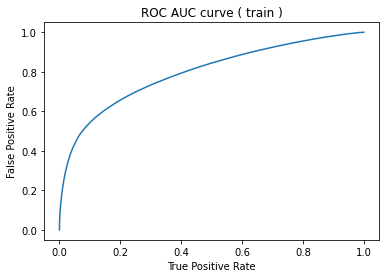

In [0]:
# run gbt model with best parameters on validation 

gbt2, gbt_validate_preds2, gbt_train_preds2, gbt_train_metrics2, gbt_validation_metrics2 = validation(df_train_list, df_validation_list, num_var, cat_var, "gbt", gbt_best_params2)
display(gbt_train_metrics2)
ROC(gbt_train_preds2, "train")

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
gbt on validation data,0.8590553890802569,0.7169680060341103,0.38985261120855624,0.5050716348268165,195814,2143216,77300,306463


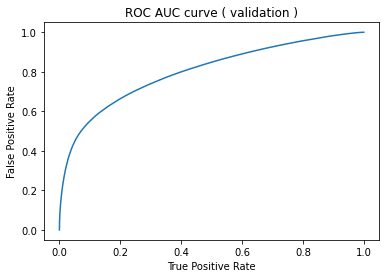

In [0]:
display(gbt_validation_metrics2)
ROC(gbt_validate_preds2, "validation")

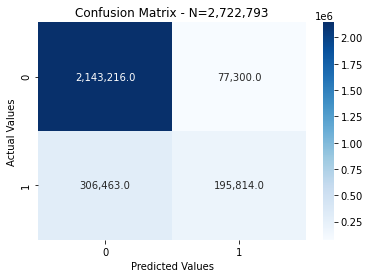

In [0]:
confusion_matrix(gbt_validate_preds2)

With the best parameters, we achieved our objective of 80% accuracy. Next, we would like to try to improve the model by applying the best parameters with different variations of feature selection.

###Round 2 Features Selection: Temporal + Location + Snowball Delay + Scaled Weather

[7, 350, 7, 0.35]
4782104
1139407
evaluation (area under ROC): 0.762370
evaluation (area under ROC): 0.765545
The accuracy is: 0.8362
The recall is: 0.3662
The precision is: 0.669
The f1_score is: 0.4733
The accuracy is: 0.8432
The recall is: 0.3583
The precision is: 0.6725
The f1_score is: 0.4675

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
gbt on train data,0.8361517132175685,0.6689547808411441,0.36616304328629706,0.4732727283103068,82933,859119,41041,143559


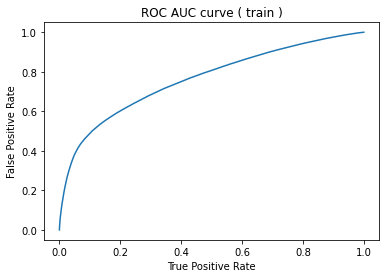

In [0]:
num_var2 = ['CRS_DEP_TIME', 'CRS_ARR_TIME', "ORIG_ELEVATION_scaled", "DEST_ELEVATION_scaled","ORIG_direction_angle_scaled", "DEST_direction_angle_scaled", "ORIG_speed_scaled", "DEST_speed_scaled", "ORIG_ceiling_height_scaled", "DEST_ceiling_height_scaled", "ORIG_vis_distance_scaled", "DEST_vis_distance_scaled", "ORIG_air_temp_scaled", "ORIG_dew_point_scaled", "DEST_dew_point_scaled", "ORIG_sea_level_pressure_scaled", "DEST_sea_level_pressure_scaled", "ORIG_precipitation_hrs_scaled", "ORIG_precipitation_depth_scaled", "DEST_precipitation_hrs_scaled", "DEST_precipitation_depth_scaled", "NUM_PREV_DELAYS_ORIGIN"]
gbt4, gbt_validate_preds4, gbt_train_preds4, gbt_train_metrics4, gbt_validation_metrics4 = validation(df_train_list, df_validation_list, num_var2, cat_var, "gbt", gbt_best_params2)
display(gbt_train_metrics4)
ROC(gbt_train_preds4, "train")

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
gbt on validation data,0.8432166907874008,0.6725473211146085,0.35826971312655054,0.467499716818591,78417,882350,38180,140460


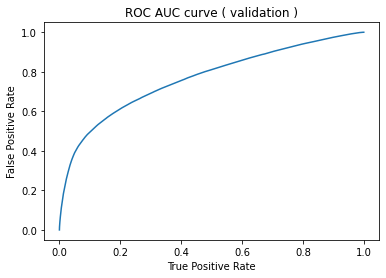

In [0]:
display(gbt_validation_metrics4)
ROC(gbt_validate_preds4, "validation")

In [0]:
#save model to Cloud
gbt2.write().overwrite().save("/mnt/v2team11/gbtc_v2")

We see the model prediction power has dropped slightly after changing the weather features to the standardized version.

###Round 3 Features Selection: Temporal + Location + Snowball Delay + Graph PageRank + Scaled Weather

[7, 350, 7, 0.35]
4782104
1139407
evaluation (area under ROC): 0.762482
evaluation (area under ROC): 0.765069
The accuracy is: 0.8362
The recall is: 0.37
The precision is: 0.6669
The f1_score is: 0.4759
The accuracy is: 0.8431
The recall is: 0.3591
The precision is: 0.6714
The f1_score is: 0.4679

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
gbt on train data,0.8362005304211061,0.6669080607039687,0.37000423856030235,0.4759492376849704,83803,858304,41856,142689


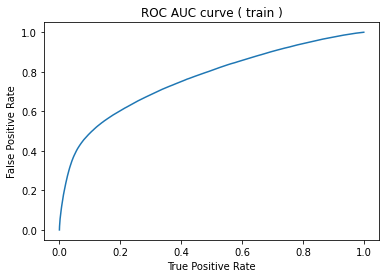

In [0]:
# run gbt model with best parameters on validation 
cat_var = ["OP_UNIQUE_CARRIER","ORIGIN","DEST","DISTANCE_GROUP", "MONTH", "DAY_OF_MONTH", "DAY_OF_WEEK", "DEP_DEL15_PREV_FIN"]
num_var3 = ['CRS_DEP_TIME', 'CRS_ARR_TIME', "ORIG_ELEVATION_scaled", "DEST_ELEVATION_scaled","ORIG_direction_angle_scaled", "DEST_direction_angle_scaled", "ORIG_speed_scaled", "DEST_speed_scaled", "ORIG_ceiling_height_scaled", "DEST_ceiling_height_scaled", "ORIG_vis_distance_scaled", "DEST_vis_distance_scaled", "ORIG_air_temp_scaled", "ORIG_dew_point_scaled", "DEST_dew_point_scaled", "ORIG_sea_level_pressure_scaled", "DEST_sea_level_pressure_scaled", "ORIG_precipitation_hrs_scaled", "ORIG_precipitation_depth_scaled", "DEST_precipitation_hrs_scaled", "DEST_precipitation_depth_scaled", "ORIGIN_page_rank_scaled", "ORIGIN_degree_centrality_scaled","DEST_page_rank_scaled", "DEST_degree_centrality_scaled", "NUM_PREV_DELAYS_ORIGIN"] 
gbt3, gbt_validate_preds3, gbt_train_preds3, gbt_train_metrics3, gbt_validation_metrics3 = validation(df_train_list, df_validation_list, num_var3, cat_var, "gbt", gbt_best_params2)
display(gbt_train_metrics3)
ROC(gbt_train_preds3, "train")

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
gbt on validation data,0.8431201493408413,0.6713613419539984,0.35912864302781927,0.46794261221573996,78605,882052,38478,140272


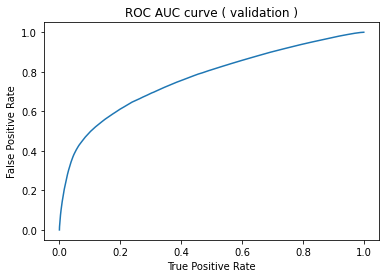

In [0]:
display(gbt_validation_metrics3)
ROC(gbt_validate_preds3, "validation")

In [0]:
#save model to Cloud
gbt3.write().overwrite().save("/mnt/v2team11/gbtc_v3")

With graph features, the model prediction power has improved. This indicators the graph features provides predictability power while not introducing additional variance.

**Summary of Model Evaluation Metrics (2015-2018)**

<img src = "https://lh3.googleusercontent.com/UZYXcmXpmcT71g_AAaL003qwgszTguHZeWVKJRbDuDlZl2oPQMVpp-f9e4EFjjPtBtZvvi2FkpXFUeRE6gYlBqhLCF8VVsOltht_M8lBotPhECVBmgwyC8VzPkDpmfDLXKKyjvzpM-c" width=70%>

<img src = "https://lh3.googleusercontent.com/e5pTqGB9vrrGQwXKDSicrWFSf6vtkW6Ec9-62lRsVBFbEo7rxTXY6ql_69XZ2co0UD_-8-YM8AJIUk4x8RUzHMq7GNB7gKDB7sR0_ydb8u9jbidIEVAb7eHh_hqEv4z_XAc-4B13Cyo" width=65%>

**Interpretation**

Given the same parameters, all three models with slightly difference in feature selection perform similarly on training and validation data in 2015 - 2018. However, model #3 with features (Temporal + Location + Snowball Delay + Graph PageRank + Scaled Weather) have the highest scores of AUC ROC, accuracy, precision and recall. The evaluation scores of the validation and training datasets are very similar. This indicates that the GBT algorithm, along with corss validation, minimized the overfitting issue. We determined the model 3 is the best GBT model and would proceed to evaluate the model on 2019 test data.

# Evaluate Model on Test data
Fit model #3 with its best parameters on full training data and evaluate on 2019 data

### GBT model evaluation

In [0]:
print(f'Number of train records: {df_2015_2018_joined.count():,}')
print(f'Number of test records: {df_test_joined.count():,}')

Number of train records: 23,910,569
Number of test records: 7,268,232

[11, 350, 9, 0.45]
7268232
3977545
evaluation (area under ROC): 0.784578
evaluation (area under ROC): 0.791267
The accuracy is: 0.8497
The recall is: 0.3713
The precision is: 0.6822
The f1_score is: 0.4809
The accuracy is: 0.85
The recall is: 0.3934
The precision is: 0.6913
The f1_score is: 0.5015

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
gbt on train data,0.8497058669076677,0.6822238664810637,0.371316005553414,0.4808942646010537,947845,10621270,441501,1604819


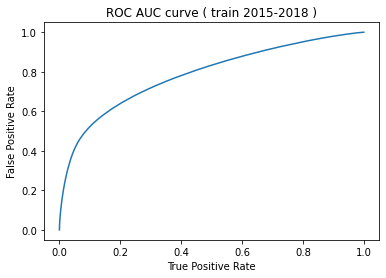

In [0]:
gbt2, gbt_test_preds2, gbt_train_preds2, gbt_train_metrics2, gbt_test_metrics2 = validation([df_2015_2018_joined], [df_test_joined], num_var, cat_var, "gbt", gbt_best_params2)
display(gbt_train_metrics2)
ROC(gbt_train_preds2, "train 2015-2018")

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
gbt on validation data,0.8499604655635574,0.6912666662060356,0.3934288485738255,0.5014573119132012,300139,3080617,134048,462741


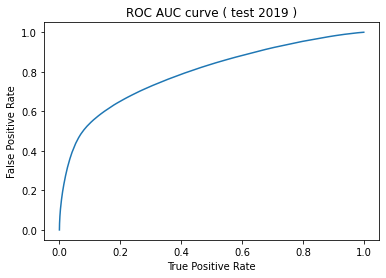

In [0]:
display(gbt_test_metrics2)
ROC(gbt_test_preds2, "test 2019")

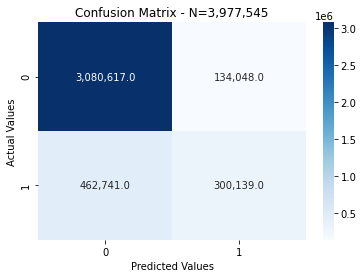

In [0]:
# Confusion matrix
confusion_matrix(gbt_test_preds2)

[11, 350, 9, 0.45]
7268232
1428214
evaluation (area under ROC): 0.778663
evaluation (area under ROC): 0.790792
The accuracy is: 0.8454
The recall is: 0.3746
The precision is: 0.694
The f1_score is: 0.4866
The accuracy is: 0.8491
The recall is: 0.4156
The precision is: 0.7149
The f1_score is: 0.5256

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
gbt on train data,0.84538951869144,0.6940167920459431,0.3746060017271157,0.4865755383747165,416442,4388949,183604,695238


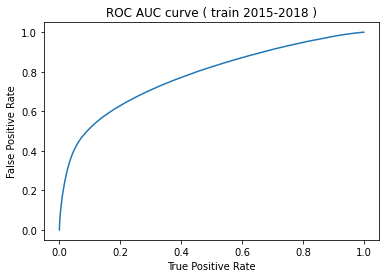

In [0]:
gbt3, gbt_test_preds3, gbt_train_preds3, gbt_train_metrics3, gbt_test_metrics3 = validation([df_2015_2018_joined], [df_test_joined], num_var3, cat_var, "gbt", gbt_best_params3)
display(gbt_train_metrics3)
ROC(gbt_train_preds3, "train 2015-2018")

Model,accuracy,precision,recall,f1_score,true_positives,true_negatives,false_positives,false_negatives
gbt on validation data,0.8491031456070309,0.7149392525882768,0.41557722830172916,0.5256225415853155,119397,1093304,47606,167907


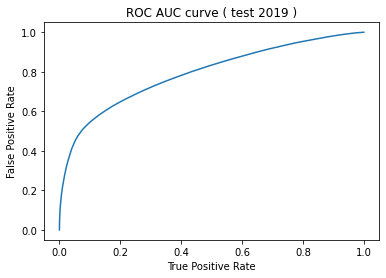

In [0]:
display(gbt_test_metrics3)
ROC(gbt_test_preds3, "test 2019")

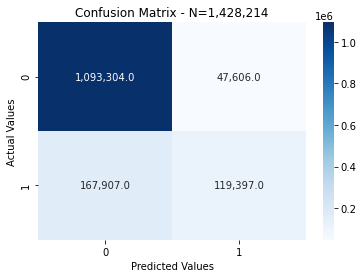

In [0]:
confusion_matrix(gbt_test_preds3)

**Evaluation metrics interpretation:**

Accuracy: TP+TN/(TP+FP+TN+TP) The GBT classfier correctly 85% of the flights in 2019

Precision: TP/(TP+FP) When the classfier predicts a flight will delay, there is 71% of the chance that the flight actually delays.

Recall: TP/(TP+FN) When a flight actually delays, there is only 42% chance that the classifier predicts that correctly.

The confusion matrix indicates that our model focuses on reducing false positives (3.33% =47606/1428214) vs. false negatives (11.76% = 167907/1428214). Once again, the evaluation scores of the training and test datasets  indicates that the GBT algorithm is not suffered from overfitting.

### Feature Importance

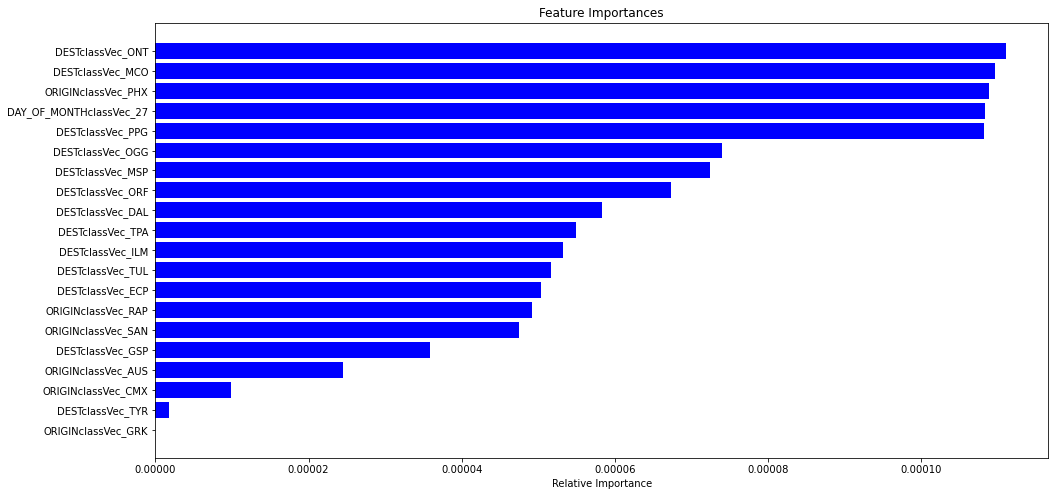

In [0]:
featureDict3 = {}
for feature in gbt_validate_preds3.schema['features'].metadata['ml_attr']['attrs']['numeric']:
    featureDict3[feature['idx']] = feature['name']
for feature in gbt_validate_preds3.schema['features'].metadata['ml_attr']['attrs']['binary']:
    featureDict3[feature['idx']] = feature['name']
    
FeatureColImportance = {}
featureIdxList = gbt3.featureImportances.indices.tolist()
featureImpList = gbt3.featureImportances.values.tolist()
featureImpDict = {}

for idx, imp in zip(featureIdxList, featureImpList):
    featureImpDict[idx] = imp
    
for key in featureImpDict:
    FeatureColImportance[featureDict3[key]] = featureImpDict[key]

features = list(FeatureColImportance.keys())
importances = list(FeatureColImportance.values())
indices = np.argsort(importances)

plt.figure(figsize=(16,8))
plt.title('Feature Importances')
plt.barh(range(20), np.array(importances)[indices[:20]], color='b', align='center')
plt.yticks(range(20), [features[i] for i in indices[:20]])
plt.xlabel('Relative Importance')
plt.show()